<a href="https://colab.research.google.com/github/AnusreeChittineni/VAIL_2021/blob/main/Airline_Sentiment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Set-up

In [12]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

### not in tutorial
import nltk
nltk.download('stopwords')

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

### Data Importation & Preparation

In [1]:
from google.colab import files

uploaded = files.upload()

Saving Tweets.csv.zip to Tweets.csv.zip


In [2]:
# unzips neccessarry zip files for session
# only needs to be run once
!unzip -uq "/content/Tweets.csv.zip" -d "/content/Tweets.csv"

In [13]:
# converts data into dataframe
df = pd.read_csv('/content/Tweets.csv/Tweets.csv')

# shuffles data
df = df.reindex(np.random.permutation(df.index)) 

# cleans data to only keep input and target
df = df[['text', 'airline_sentiment']]

# remove stopwords and mentions from tweets
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [14]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [16]:
# converts words to numbers
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(x_train)

In [18]:
# converts text data to a vector
x_train_oh = tk.texts_to_matrix(x_train, mode='binary')
x_test_oh = tk.texts_to_matrix(x_test, mode='binary')

In [19]:
# Converting the target classes to numbers
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [20]:
# Splitting off a validation set
x_train_rest, x_val, y_train_rest, y_val = train_test_split(x_train_oh, y_train_oh, test_size=0.1, random_state=37)

### Deep Learning

Minimum validation loss reached in epoch 3


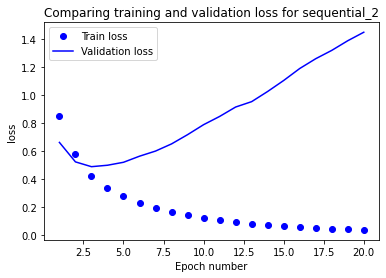

In [23]:
# Baseline model with overfitting
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
#base_model.name = 'Baseline model'

base_history = deep_model(base_model, x_train_rest, y_train_rest, x_val, y_val)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

Minimum validation loss reached in epoch 11


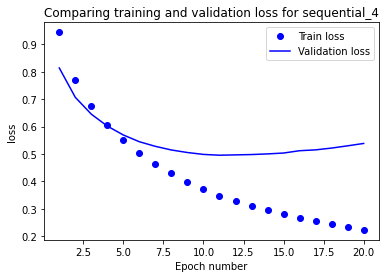

In [25]:
# Reducing the network's capacity
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
#reduced_model.name = 'Reduced model'
reduced_history = deep_model(reduced_model, x_train_rest, y_train_rest, x_val, y_val)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

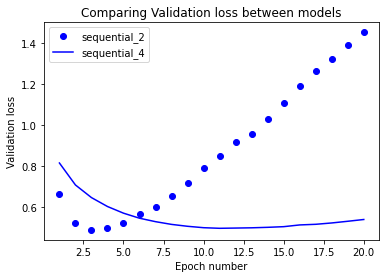

In [26]:
# compares baseline with reduced model
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

Minimum validation loss reached in epoch 4


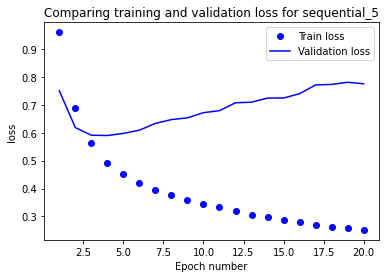

In [27]:
# L2 Regularization
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
#reg_model.name = 'L2 Regularization model'
reg_history = deep_model(reg_model, x_train_rest, y_train_rest, x_val, y_val)
reg_min = optimal_epoch(reg_history)

eval_metric(reg_model, reg_history, 'loss')

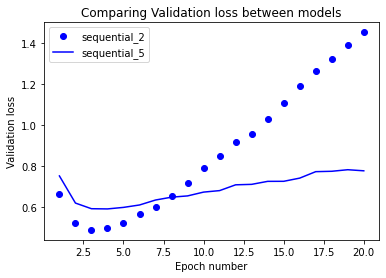

In [28]:
# compares baseline with L2 Regularization model
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

Minimum validation loss reached in epoch 5


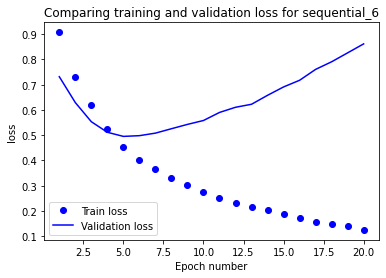

In [29]:
# Adding dropout layers
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
#drop_model.name = 'Dropout layers model'
drop_history = deep_model(drop_model, x_train_rest, y_train_rest, x_val, y_val)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

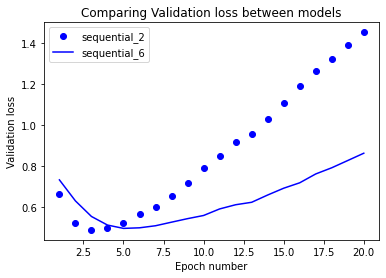

In [30]:
# compares baseline with drop model
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [32]:
for i in range(5):
  base_results = test_model(base_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, base_min)
  reduced_results = test_model(reduced_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, reduced_min)
  reg_results = test_model(reg_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, reg_min)
  drop_results = test_model(drop_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, drop_min)
  print("-" * 10)

46/46 [==============================] - 0s 2ms/step - loss: 1.2276 - accuracy: 0.7643

Test accuracy: 76.43%
46/46 [==============================] - 0s 2ms/step - loss: 0.7411 - accuracy: 0.7801

Test accuracy: 78.01%
46/46 [==============================] - 0s 2ms/step - loss: 0.7516 - accuracy: 0.7937

Test accuracy: 79.37%
46/46 [==============================] - 0s 2ms/step - loss: 0.9773 - accuracy: 0.7889

Test accuracy: 78.89%
----------
46/46 [==============================] - 0s 2ms/step - loss: 1.4103 - accuracy: 0.7671

Test accuracy: 76.71%
46/46 [==============================] - 0s 2ms/step - loss: 0.8831 - accuracy: 0.7760

Test accuracy: 77.60%
46/46 [==============================] - 0s 2ms/step - loss: 0.7670 - accuracy: 0.7958

Test accuracy: 79.58%
46/46 [==============================] - 0s 2ms/step - loss: 1.1256 - accuracy: 0.7821

Test accuracy: 78.21%
----------
46/46 [==============================] - 0s 2ms/step - loss: 1.5978 - accuracy: 0.7643

Test accur